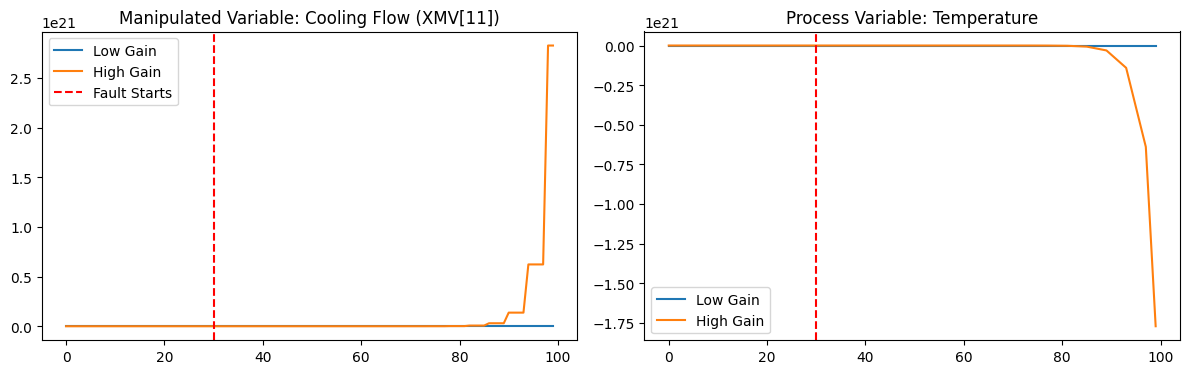

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_pid(K_p: float, K_i: float, fault_start: int) -> dict[str, np.ndarray]:
    setpoint = 100.0
    T = np.zeros(100)
    u = np.zeros(100)
    e = np.zeros(100)
    T[0] = 95.0
    integral = 0.0
    stuck = False
    stuck_count = 0
    last_u = 0.0

    for t in range(1, 100):
        # Error
        e[t] = setpoint - T[t-1]
        integral += e[t]

        # Controller output
        delta_u = K_p * e[t] + K_i * integral

        if t >= fault_start:
            if not stuck:
                last_u = u[t-1] + delta_u
                stuck = True
                stuck_count = 3
            else:
                stuck_count -= 1
                if stuck_count == 0:
                    stuck = False
            u[t] = last_u
        else:
            u[t] = u[t-1] + delta_u

        # Process response: temperature affected by cooling flow
        T[t] = T[t-1] - 0.2 * (u[t] - 5.0) + np.random.normal(0, 0.1)

    return {'T': T, 'u': u, 'e': e}


low_gain = simulate_pid(K_p=0.5, K_i=0.1, fault_start=30)
high_gain = simulate_pid(K_p=2.0, K_i=0.4, fault_start=30)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(low_gain['u'], label='Low Gain')
plt.plot(high_gain['u'], label='High Gain')
plt.axvline(30, color='r', linestyle='--', label='Fault Starts')
plt.title("Manipulated Variable: Cooling Flow (XMV[11])")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(low_gain['T'], label='Low Gain')
plt.plot(high_gain['T'], label='High Gain')
plt.axvline(30, color='r', linestyle='--')
plt.title("Process Variable: Temperature")
plt.legend()
plt.tight_layout()
plt.show()




## ▶ Setup: Simulated Subsystem (Simplified)

We simulate:

* A **process variable**: Reactor temperature $T$
* A **manipulated variable**: Cooling water flow rate $Q$ (XMV\[11])
* A **fault**: Valve stiction starts at time $t = 30$ minutes
* A **PID controller** controls $Q$ to keep $T$ near a setpoint

We simulate for 100 timesteps (1 minute each). Fault starts at step 30.

---

## ▶ PID Controller Equation (Discrete Form)

Let:

* $e_t = \text{setpoint} - T_t$
* $u_t = u_{t-1} + K_p (e_t - e_{t-1}) + K_i e_t + K_d (e_t - 2e_{t-1} + e_{t-2})$

We'll simulate two cases:

1. **Low gain PID**: $K_p = 0.5, K_i = 0.1, K_d = 0.0$
2. **High gain PID**: $K_p = 2.0, K_i = 0.4, K_d = 0.0$

Fault effect: the valve (XMV\[11]) cannot change freely — it **sticks** for 3 timesteps once moved (simulated as no change in `u_t` for 3 steps after a change).

---

## ▶ Interpretation

* **Low gain PID**: The valve signal (`u_t`) changes slowly and masks the stiction effect → small variance → **harder to detect** with CUSUM → higher **ARLₒ.c**.
* **High gain PID**: The controller reacts faster and overcomes stiction more visibly → larger variance or clear patterns in `u_t` → **easier detection** → lower **ARLₒ.c**.

---

## ▶ Summary

If you want to:

* **Increase detection sensitivity**, use **aggressive PID tuning** (higher `Kp`, `Ki`).
* **Reduce actuator wear or noise**, use **conservative tuning**, but at the cost of detection speed.

